<a href="https://colab.research.google.com/github/gabipalacios/Python/blob/main/RiesgoZ2capa_V12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [534]:
import numpy as np
import pandas as pd
import datetime as dt
import io
from google.colab import files
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sn
from google.colab import drive
pd.options.display.float_format = '{:.2f}'.format

drive.mount('/content/drive')
origen = pd.read_csv('/content/drive/MyDrive/1Empleos/VALOR/1bbddPhyton/bbdd_sinpagos3.csv')
marco = pd.read_csv('/content/drive/MyDrive/1Empleos/VALOR/1bbddPhyton/bbdd_PreMarcoBCU3.csv')

#Variables seleccionadas del maro:
marco = marco.add_prefix('m_')
#Variables seleccionadas de Financial y PLataforma
origen = origen.add_prefix('o_')


#join de las dos tablas
df = pd.merge(origen, marco, left_on='o_Documento', right_on='m_Documento', how='inner')
#Defino índice documento
df = df.set_index('m_Documento')
#Quito registros que no tienen score
#df = df.dropna(subset=['o_clr_score'])

#Reorganizo valores de variables con criterio lógico, para obtener mejore conclusiones, (analizados previamente)
df.loc[~df['o_dispositivo_marca'].isin(['Apple']), 'o_dispositivo_marca'] = 'Android'
df.loc[df['o_sist_op_familia'] != 'iOS', 'o_sist_op_familia'] = 'Android'
df.loc[df['o_dispositivo_marca'] != 'Apple', 'o_dispositivo_marca'] = 'Android'
df.loc[~df['o_navegador_familia'].isin(['Facebook', 'Instagram']), 'o_navegador_familia'] = 'Web'
df.loc[~df['o_departamento'].isin(['MONTEVIDEO', 'CANELONES']), 'o_departamento'] = 'RESTO'
print(df.shape)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(1825, 53)


In [535]:
print(marco.shape)
print(origen.shape)
print(df.shape)

(2445, 20)
(2746, 34)
(1825, 53)


In [536]:
df = df.drop(['o_Documento','o_Date'], axis=1)

In [537]:
marco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2445 entries, 0 to 2444
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   m_Documento           2445 non-null   int64  
 1   m_Deuda               2445 non-null   int64  
 2   m_DeudaPrincipal      2445 non-null   int64  
 3   m_DeudaSec_Prom       2445 non-null   int64  
 4   m_Entidades           2445 non-null   int64  
 5   m_TieneBco            2445 non-null   int64  
 6   m_TieneFin            2445 non-null   int64  
 7   m_Rel_Deuda_Fin       2445 non-null   float64
 8   m_Rel_DeudaPrincipal  2445 non-null   float64
 9   m_Rel_Contingencia    2445 non-null   float64
 10  m_Var_dueda_6M        2445 non-null   float64
 11  m_Deuda_Var-6         2444 non-null   float64
 12  m_Rel_VarDeuda_Deuda  2419 non-null   float64
 13  m_1PEORCATBCU6M       2445 non-null   object 
 14  m_Sin_Ficha           2445 non-null   int64  
 15  m_Malos              

In [538]:
#Modificar el parámetro de la tabla df['hora'] donde se muestran las horas del día desde 0 a 23,
#son tipos de datos periódicos, utilizando el cálculo trigonométrico más adecuado para introducir el parámetro en un modelo predictivo.
df['o_Hora'] = pd.to_numeric(df['o_Hora'])

# Calcular la representación sinusoidal de la hora
df['hora_sin'] = np.sin(2 * np.pi * df['o_Hora'] / 24)
df['hora_cos'] = np.cos(2 * np.pi * df['o_Hora'] / 24)

# Eliminar la columna original 'hora'
df = df.drop('o_Hora', axis=1)


In [539]:
origen.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2746 entries, 0 to 2745
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   o_Date                 2746 non-null   object 
 1   o_Documento            2746 non-null   int64  
 2   o_fpd4                 2746 non-null   int64  
 3   o_quincena             2746 non-null   int64  
 4   o_Hora                 2746 non-null   int64  
 5   o_Num_Dia_Sem          2746 non-null   int64  
 6   o_canal                2746 non-null   object 
 7   o_status_usuario       2746 non-null   object 
 8   o_status               2746 non-null   object 
 9   o_sist_op_familia      2738 non-null   object 
 10  o_cargo                2745 non-null   object 
 11  o_relacion_laboral     2745 non-null   object 
 12  o_nivel_educativo      2745 non-null   object 
 13  o_navegador_familia    2738 non-null   object 
 14  o_dispositivo_familia  2738 non-null   object 
 15  o_de

In [540]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1825 entries, 10994184 to 9531591
Data columns (total 52 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   o_fpd4                 1825 non-null   int64  
 1   o_quincena             1825 non-null   int64  
 2   o_Num_Dia_Sem          1825 non-null   int64  
 3   o_canal                1825 non-null   object 
 4   o_status_usuario       1825 non-null   object 
 5   o_status               1825 non-null   object 
 6   o_sist_op_familia      1825 non-null   object 
 7   o_cargo                1825 non-null   object 
 8   o_relacion_laboral     1825 non-null   object 
 9   o_nivel_educativo      1825 non-null   object 
 10  o_navegador_familia    1825 non-null   object 
 11  o_dispositivo_familia  1822 non-null   object 
 12  o_departamento         1825 non-null   object 
 13  o_localidad            1824 non-null   object 
 14  o_ingreso_estimado     1825 non-null   float64
 15 

In [541]:
print(df.o_relacion_laboral.unique())
df.o_relacion_laboral.value_counts()

['jubilado' 'indep_sin_local' 'emp_privado' 'indep_con_local' 'otros'
 'emp_publico']


,count
o_relacion_laboral,
emp_privado,668
indep_sin_local,339
jubilado,227
emp_publico,214
indep_con_local,192
otros,185


In [542]:
# prompt: listar los campos que se deben categorizar para aplicar en un modelo predictivo

# Select categorical features for encoding
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

print("Categorical features to be categorized for predictive modeling:")
categorical_features


Categorical features to be categorized for predictive modeling:


['o_canal',
 'o_status_usuario',
 'o_status',
 'o_sist_op_familia',
 'o_cargo',
 'o_relacion_laboral',
 'o_nivel_educativo',
 'o_navegador_familia',
 'o_dispositivo_familia',
 'o_departamento',
 'o_localidad',
 'o_genero',
 'o_dispositivo_marca',
 'o_cel_carrier',
 'o_email',
 'm_1PEORCATBCU6M',
 'm_Grupo_b',
 'm_Grupo_i',
 'm_Situacion-6CDR']

In [543]:
columns_to_categorize = ['o_canal',
 'o_status_usuario',
 'o_status',
 'o_sist_op_familia',
 'o_cargo',
 'o_relacion_laboral',
 'o_nivel_educativo',
 'o_navegador_familia',
 'o_dispositivo_familia',
 'o_departamento',
 'o_localidad',
 'o_genero',
 'o_dispositivo_marca',
 'o_cel_carrier',
 'o_email',
 'm_1PEORCATBCU6M',
 'm_Grupo_b',
 'm_Grupo_i',
 'm_Situacion-6CDR']

for col in columns_to_categorize:
  if col in df.columns:
    df[col] = df[col].astype('category')
  else:
    print(f"Warning: Column '{col}' not found in DataFrame.")

In [544]:
df_cat = df.select_dtypes(include=['object'])

# Transform all categorical variables into 'category' dtype
for col in df_cat.columns:
  df[col] = df[col].astype('category')

#df.info()

In [545]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1825 entries, 10994184 to 9531591
Data columns (total 52 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   o_fpd4                 1825 non-null   int64   
 1   o_quincena             1825 non-null   int64   
 2   o_Num_Dia_Sem          1825 non-null   int64   
 3   o_canal                1825 non-null   category
 4   o_status_usuario       1825 non-null   category
 5   o_status               1825 non-null   category
 6   o_sist_op_familia      1825 non-null   category
 7   o_cargo                1825 non-null   category
 8   o_relacion_laboral     1825 non-null   category
 9   o_nivel_educativo      1825 non-null   category
 10  o_navegador_familia    1825 non-null   category
 11  o_dispositivo_familia  1822 non-null   category
 12  o_departamento         1825 non-null   category
 13  o_localidad            1824 non-null   category
 14  o_ingreso_estimado     1825 non-nul

In [546]:
df_cat = df.select_dtypes(include=['category'])
display(df_cat)

,o_canal,o_status_usuario,o_status,o_sist_op_familia,o_cargo,o_relacion_laboral,o_nivel_educativo,o_navegador_familia,o_dispositivo_familia,o_departamento,o_localidad,o_genero,o_dispositivo_marca,o_cel_carrier,o_email,m_1PEORCATBCU6M,m_Grupo_b,m_Grupo_i,m_Situacion-6CDR
m_Documento,,,,,,,,,,,,,,,,,,,
10994184,WA,id_verified,voucher_issued,Android,BPS / AFAP,jubilado,Secundaria - Bachillerato,Web,K,CANELONES,SOLYMAR,femenino,Android,CLARO,gmail.com,1C,R,B1,Buena
11105982,WA,id_verified,voucher_issued,Android,BPS / AFAP,jubilado,Secundaria - Ciclo Básico,Web,Other,CANELONES,LAS TOSCAS,masculino,Android,CLARO,gmail.com,1C,B1,B1,Buena
11150103,WA,id_verified,voucher_issued,Android,BPS / AFAP,jubilado,Secundaria - Ciclo Básico,Web,K,MONTEVIDEO,MONTEVIDEO,femenino,Android,MOVISTAR,gmail.com,1C,C,C,Buena
11349815,WA,id_verified,voucher_issued,Android,BPS / AFAP,jubilado,Primaria,Facebook,M2004J19C,CANELONES,LAS PIEDRAS,masculino,Android,MOVISTAR,gmail.com,1C,B1,B1,Buena
12099611,WA,id_verified,voucher_issued,Android,Otra,jubilado,Secundaria - Bachillerato,Instagram,Samsung SM-G975F,MONTEVIDEO,MONTEVIDEO,femenino,Android,ANTEL,hotmail.com,2A,R,B1,Peor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57617232,WA,id_verified,voucher_issued,Android,Vendedor / Auxiliar Comercio o Servicios,emp_privado,Secundaria - Bachillerato,Web,Other,CANELONES,LAS PIEDRAS,femenino,Android,MOVISTAR,gmail.com,1C,B1,B1,Buena
58010932,WA,id_verified,voucher_issued,Android,Otros,indep_sin_local,Secundaria - Ciclo Básico,Web,K,CANELONES,TOLEDO,femenino,Android,CLARO,gmail.com,1C,C,C,Buena
58037130,WA,id_verified,voucher_issued,iOS,Vendedor / Auxiliar Comercio o Servicios,emp_privado,Secundaria - Bachillerato,Instagram,iPhone,MONTEVIDEO,MONTEVIDEO,femenino,Apple,CLARO,gmail.com,2B,R,C,Mejor


In [547]:
for column in df_cat.columns:
  print(f"Unique values for {column}: {df_cat[column].unique()}")

Unique values for o_canal: ['WA']
Categories (1, object): ['WA']
Unique values for o_status_usuario: ['id_verified', 'bureau_validated', 'user_unvalidated_image']
Categories (3, object): ['bureau_validated', 'id_verified', 'user_unvalidated_image']
Unique values for o_status: ['voucher_issued']
Categories (1, object): ['voucher_issued']
Unique values for o_sist_op_familia: ['Android', 'iOS']
Categories (2, object): ['Android', 'iOS']
Unique values for o_cargo: ['BPS / AFAP', 'Otra', 'Caja Militar / Policial', 'Profesional Universitario', 'Administrativo / Contable / Oficinista', ..., 'Chofer / Taxista / Remisero', 'Maestro / Profesor / Docente', 'Camionero', 'Militar / Policía / Bombero', 'Portero']
Length: 29
Categories (29, object): ['Administrativo / Contable / Oficinista', 'Albañil / Obrero Construcción', 'BPS / AFAP',
                          'Caja Bancaria', ..., 'Repartidor', 'Trabajador Rural',
                          'Técnico / Profesional no universitario', 'Vendedor / Aux

In [548]:
for col in df_cat.columns:
  print(f"\nValue counts for {col}:")
  print(df_cat[col].value_counts())


Value counts for o_canal:
o_canal
WA    1825
Name: count, dtype: int64

Value counts for o_status_usuario:
o_status_usuario
id_verified               1821
bureau_validated             3
user_unvalidated_image       1
Name: count, dtype: int64

Value counts for o_status:
o_status
voucher_issued    1825
Name: count, dtype: int64

Value counts for o_sist_op_familia:
o_sist_op_familia
Android    1595
iOS         230
Name: count, dtype: int64

Value counts for o_cargo:
o_cargo
Otros                                        420
Comerciante                                  166
Empleo doméstico / Limpiador                 165
BPS / AFAP                                   160
Vendedor / Auxiliar Comercio o Servicios     122
Administrativo / Contable / Oficinista       121
Enfermero / Personal Salud                    64
Cocinero                                      62
Obrero / Peon                                 61
Albañil / Obrero Construcción                 59
Maestro / Profesor / Docente    

In [549]:
# prompt: mantene sólo los 3 primeros caracteres de un campo

if 'o_dispositivo_familia' in df.columns:
  df['o_dispositivo_familia'] = df['o_dispositivo_familia'].astype(str).str[:3]
  print(f"Unique values for o_dispositivo_familia after truncation: {df['o_dispositivo_familia'].unique()}")
else:
  print("Column 'o_dispositivo_familia' not found in DataFrame.")

print(df.o_dispositivo_familia.unique())
df.o_dispositivo_familia.value_counts()

Unique values for o_dispositivo_familia after truncation: ['K' 'Oth' 'M20' 'Sam' '220' 'iPh' '230' 'ZTE' 'Mot' 'Hua' '231' 'Xia'
 '221' 'MP0' '240' 'Nok' 'JKM' '513' 'nan' 'iPa' '211' 'YAL' 'Opp' 'M21'
 'Mac' 'VOG' '210' '503' 'BNE' 'NAM' 'MGA' 'TEC' 'FRL' 'Eli' 'LM-' 'MED'
 '510' 'CTR' 'Z23' 'E60' 'G63' 'L62' 'NCO' 'Gen' 'STK' 'BOL']
['K' 'Oth' 'M20' 'Sam' '220' 'iPh' '230' 'ZTE' 'Mot' 'Hua' '231' 'Xia'
 '221' 'MP0' '240' 'Nok' 'JKM' '513' 'nan' 'iPa' '211' 'YAL' 'Opp' 'M21'
 'Mac' 'VOG' '210' '503' 'BNE' 'NAM' 'MGA' 'TEC' 'FRL' 'Eli' 'LM-' 'MED'
 '510' 'CTR' 'Z23' 'E60' 'G63' 'L62' 'NCO' 'Gen' 'STK' 'BOL']


,count
o_dispositivo_familia,
K,483
Sam,384
Oth,295
iPh,229
231,73
Mot,60
220,49
230,44
Hua,43


In [550]:
# prompt: Todos los registros de 'o_dispositivo_familia' que tengan menos de 10 registros y empiecen con un caracter numerico, agruparlos con 'NUM'

if 'o_dispositivo_familia' in df.columns:
  # Get value counts
  value_counts = df['o_dispositivo_familia'].value_counts()

  # Identify categories with less than 10 records that start with a digit
  categories_to_group = [cat for cat, count in value_counts.items()
                         if count < 50]

  # Replace these categories with 'NUM'
  df['o_dispositivo_familia'] = df['o_dispositivo_familia'].replace(categories_to_group, 'NUM')

  print(f"Unique values for o_dispositivo_familia after grouping: {df['o_dispositivo_familia'].unique()}")
  print(f"\nValue counts for o_dispositivo_familia after grouping:")
  print(df['o_dispositivo_familia'].value_counts())
else:
  print("Column 'o_dispositivo_familia' not found in DataFrame.")


Unique values for o_dispositivo_familia after grouping: ['K' 'Oth' 'NUM' 'Sam' 'iPh' 'Mot' '231']

Value counts for o_dispositivo_familia after grouping:
o_dispositivo_familia
K      483
Sam    384
NUM    301
Oth    295
iPh    229
231     73
Mot     60
Name: count, dtype: int64


In [551]:
#Dropear variables con poca varianza
columns_to_drop = ['o_canal', 'o_status_usuario', 'o_email','o_localidad']
df = df.drop(columns=columns_to_drop, errors='ignore')
#df.info()


In [552]:
cargo_counts = df['o_cargo'].value_counts()
categories_to_group = cargo_counts[cargo_counts <= 100].index.tolist()

# Replace these categories with 'otros'
df['o_cargo'] = df['o_cargo'].replace(categories_to_group, 'Otros')

print("\nValue counts for o_cargo after grouping categories with count <= 50 into 'otros':")
print(df['o_cargo'].value_counts())
print("\nUnique values for o_cargo after grouping:")
print(df['o_cargo'].unique())



Value counts for o_cargo after grouping categories with count <= 50 into 'otros':
o_cargo
Otros                                       1091
Comerciante                                  166
Empleo doméstico / Limpiador                 165
BPS / AFAP                                   160
Vendedor / Auxiliar Comercio o Servicios     122
Administrativo / Contable / Oficinista       121
Name: count, dtype: int64

Unique values for o_cargo after grouping:
['BPS / AFAP', 'Otros', 'Administrativo / Contable / Oficinista', 'Comerciante', 'Empleo doméstico / Limpiador', 'Vendedor / Auxiliar Comercio o Servicios']
Categories (6, object): ['Administrativo / Contable / Oficinista', 'BPS / AFAP', 'Comerciante',
                         'Empleo doméstico / Limpiador', 'Otros', 'Vendedor / Auxiliar Comercio o Servicios']


<ipython-input-552-1790253386>:5: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df['o_cargo'] = df['o_cargo'].replace(categories_to_group, 'Otros')


In [553]:
# Replace 'INDEPENDIENTE' and 'INDEPENDIENTE.' with 'INDEPENDIENTE' in 'o_relacion_laboral' column
df['o_cargo'] = df['o_cargo'].replace(['Militar / Policía / Bombero', 'Caja Militar / Policial','Profesional Universitario','Guardias Seguridad'], 'Seguridad&ProfUniv')
df['o_cargo'] = df['o_cargo'].replace(['Albañil / Obrero Construcción', 'Obrero / Peon'], 'Construccion')
print(df.o_cargo.unique())
print(df.o_cargo.value_counts())

['BPS / AFAP', 'Otros', 'Administrativo / Contable / Oficinista', 'Comerciante', 'Empleo doméstico / Limpiador', 'Vendedor / Auxiliar Comercio o Servicios']
Categories (6, object): ['Administrativo / Contable / Oficinista', 'BPS / AFAP', 'Comerciante',
                         'Empleo doméstico / Limpiador', 'Otros', 'Vendedor / Auxiliar Comercio o Servicios']
o_cargo
Otros                                       1091
Comerciante                                  166
Empleo doméstico / Limpiador                 165
BPS / AFAP                                   160
Vendedor / Auxiliar Comercio o Servicios     122
Administrativo / Contable / Oficinista       121
Name: count, dtype: int64


##TR Características Nominales

In [554]:
df_cat.columns

Index(['o_canal', 'o_status_usuario', 'o_status', 'o_sist_op_familia',
       'o_cargo', 'o_relacion_laboral', 'o_nivel_educativo',
       'o_navegador_familia', 'o_dispositivo_familia', 'o_departamento',
       'o_localidad', 'o_genero', 'o_dispositivo_marca', 'o_cel_carrier',
       'o_email', 'm_1PEORCATBCU6M', 'm_Grupo_b', 'm_Grupo_i',
       'm_Situacion-6CDR'],
      dtype='object')

In [555]:
# prompt: listar los campos que son variables nominales del dataset df

# Nominal variables are typically those with no inherent order.
# In this context, we can assume that all variables with 'category' dtype are treated as nominal
# for the purpose of listing them, as the conversion to category was intended for this purpose.

nominal_variables = df_cat.columns.tolist()

print("Variables that are considered nominal based on 'category' dtype:")
nominal_variables

Variables that are considered nominal based on 'category' dtype:


['o_canal',
 'o_status_usuario',
 'o_status',
 'o_sist_op_familia',
 'o_cargo',
 'o_relacion_laboral',
 'o_nivel_educativo',
 'o_navegador_familia',
 'o_dispositivo_familia',
 'o_departamento',
 'o_localidad',
 'o_genero',
 'o_dispositivo_marca',
 'o_cel_carrier',
 'o_email',
 'm_1PEORCATBCU6M',
 'm_Grupo_b',
 'm_Grupo_i',
 'm_Situacion-6CDR']

In [556]:
# Identify nominal columns that are still in the DataFrame
nominal_vars_existing = [col for col in ['o_canal',
 'o_status_usuario',
 'o_status',
 'o_sist_op_familia',
 'o_cargo',
 'o_relacion_laboral',
 'o_nivel_educativo',
 'o_navegador_familia',
 'o_dispositivo_familia',
 'o_departamento',
 'o_localidad',
 'o_genero',
 'o_dispositivo_marca',
 'o_cel_carrier',
 'o_email',
 'm_1PEORCATBCU6M',
 'm_Grupo_b',
 'm_Grupo_i',
 'm_Situacion-6CDR'] if col in df.columns]


# Apply One-Hot Encoding to existing nominal columns
df = pd.get_dummies(df, columns=nominal_vars_existing)

# Display the first few rows of the dataframe with one-hot encoded variables
display(df.head())

# Display the information of the updated dataframe
#df.info()

,o_fpd4,o_quincena,o_Num_Dia_Sem,o_ingreso_estimado,o_ingreso_declarado,o_edad,o_clr_Score3,o_clr_Cancelaciones,o_clr_Consultas,o_clr_Incumplimientos,...,m_Grupo_b_M,m_Grupo_b_R,m_Grupo_b_RR,m_Grupo_i_A,m_Grupo_i_B1,m_Grupo_i_C,m_Grupo_i_C1,m_Situacion-6CDR_Buena,m_Situacion-6CDR_Mejor,m_Situacion-6CDR_Peor
m_Documento,,,,,,,,,,,,,,,,,,,,,
10994184,1,2,7,26369.00,42600.00,76,940,0,0,0,...,False,True,False,False,True,False,False,True,False,False
11105982,1,2,5,54066.00,50000.00,78,717,0,0,0,...,False,False,False,False,True,False,False,True,False,False
11150103,1,1,4,31138.00,45000.00,78,923,0,0,0,...,False,False,False,False,False,True,False,True,False,False
11349815,1,2,3,33422.00,18000.00,77,564,0,0,0,...,False,False,False,False,True,False,False,True,False,False
12099611,1,2,2,105902.00,30000.00,73,507,0,1,0,...,False,True,False,False,True,False,False,False,False,True


##TR Características Ordinales

In [557]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1825 entries, 10994184 to 9531591
Data columns (total 94 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   o_fpd4                                            1825 non-null   int64  
 1   o_quincena                                        1825 non-null   int64  
 2   o_Num_Dia_Sem                                     1825 non-null   int64  
 3   o_ingreso_estimado                                1825 non-null   float64
 4   o_ingreso_declarado                               1825 non-null   float64
 5   o_edad                                            1825 non-null   int64  
 6   o_clr_Score3                                      1825 non-null   int64  
 7   o_clr_Cancelaciones                               1825 non-null   int64  
 8   o_clr_Consultas                                   1825 non-null   int64  
 9   o_clr_Incumpli

##Datos numéricos

In [558]:
df_numeric = df.select_dtypes(include=np.number)
df_numeric.info()
display(df_numeric.head())

<class 'pandas.core.frame.DataFrame'>
Index: 1825 entries, 10994184 to 9531591
Data columns (total 33 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   o_fpd4                 1825 non-null   int64  
 1   o_quincena             1825 non-null   int64  
 2   o_Num_Dia_Sem          1825 non-null   int64  
 3   o_ingreso_estimado     1825 non-null   float64
 4   o_ingreso_declarado    1825 non-null   float64
 5   o_edad                 1825 non-null   int64  
 6   o_clr_Score3           1825 non-null   int64  
 7   o_clr_Cancelaciones    1825 non-null   int64  
 8   o_clr_Consultas        1825 non-null   int64  
 9   o_clr_Incumplimientos  1825 non-null   int64  
 10  o_cdr_tiene_quita      1825 non-null   int64  
 11  o_cdr_tiene_oca        1825 non-null   int64  
 12  o_cdr_tiene_brou       1825 non-null   int64  
 13  o_cdr_segmento         1825 non-null   int64  
 14  o_pricing              1825 non-null   int64  
 15 

,o_fpd4,o_quincena,o_Num_Dia_Sem,o_ingreso_estimado,o_ingreso_declarado,o_edad,o_clr_Score3,o_clr_Cancelaciones,o_clr_Consultas,o_clr_Incumplimientos,...,m_Rel_DeudaPrincipal,m_Rel_Contingencia,m_Var_dueda_6M,m_Deuda_Var-6,m_Rel_VarDeuda_Deuda,m_Sin_Ficha,m_Malos,m_Q_irregular_12m,hora_sin,hora_cos
m_Documento,,,,,,,,,,,,,,,,,,,,,
10994184,1,2,7,26369.00,42600.00,76,940,0,0,0,...,1.00,3.68,-0.83,-30293.00,-4.94,0,0,0,-0.50,-0.87
11105982,1,2,5,54066.00,50000.00,78,717,0,0,0,...,0.95,0.74,10.00,93871.00,0.91,0,0,0,-0.87,-0.50
11150103,1,1,4,31138.00,45000.00,78,923,0,0,0,...,0.73,0.62,-0.38,-38290.00,-0.60,0,0,0,-0.26,-0.97
11349815,1,2,3,33422.00,18000.00,77,564,0,0,0,...,0.67,0.00,1.66,90846.00,0.62,0,0,0,-0.87,0.50
12099611,1,2,2,105902.00,30000.00,73,507,0,1,0,...,0.72,1.02,0.56,131761.00,0.36,0,0,2,-0.50,-0.87


In [559]:
df.describe()

,o_fpd4,o_quincena,o_Num_Dia_Sem,o_ingreso_estimado,o_ingreso_declarado,o_edad,o_clr_Score3,o_clr_Cancelaciones,o_clr_Consultas,o_clr_Incumplimientos,...,m_Rel_DeudaPrincipal,m_Rel_Contingencia,m_Var_dueda_6M,m_Deuda_Var-6,m_Rel_VarDeuda_Deuda,m_Sin_Ficha,m_Malos,m_Q_irregular_12m,hora_sin,hora_cos
count,1825.00,1825.00,1825.00,1825.00,1825.00,1825.00,1825.00,1825.00,1825.00,1825.00,...,1825.00,1825.00,1825.00,1824.00,1801.00,1825.00,1825.00,1825.00,1825.00,1825.00
mean,0.39,1.50,4.07,32432.95,39914.27,44.04,595.59,0.04,1.18,0.35,...,0.66,inf,1.45,71537.06,0.29,0.32,0.17,0.91,-0.44,-0.06
std,0.49,0.50,1.79,17424.37,32740.46,12.61,200.15,0.19,1.25,0.48,...,0.24,NaN,2.61,145617.44,0.50,0.73,0.54,1.77,0.54,0.72
min,0.00,1.00,1.00,9684.00,30.00,21.00,41.00,0.00,0.00,0.00,...,0.00,0.00,-1.00,-245439.00,-7.61,0.00,0.00,0.00,-1.00,-1.00
25%,0.00,1.00,3.00,20482.00,24000.00,34.00,475.00,0.00,0.00,0.00,...,0.48,0.01,0.07,5019.50,0.07,0.00,0.00,0.00,-0.87,-0.71
50%,0.00,2.00,4.00,26919.00,32000.00,42.00,612.00,0.00,1.00,0.00,...,0.64,0.09,0.48,36560.50,0.33,0.00,0.00,0.00,-0.50,-0.00
75%,1.00,2.00,6.00,38975.00,47000.00,53.00,747.00,0.00,3.00,1.00,...,0.88,0.27,1.18,92560.25,0.55,0.00,0.00,1.00,-0.26,0.71
max,1.00,2.00,7.00,143284.00,560000.00,82.00,942.00,1.00,3.00,1.00,...,1.00,inf,10.00,2899726.00,0.91,3.00,3.00,12.00,1.00,1.00



Info after transformation:
<class 'pandas.core.frame.DataFrame'>
Index: 1825 entries, 10994184 to 9531591
Data columns (total 94 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   o_fpd4                                            1825 non-null   int64  
 1   o_quincena                                        1825 non-null   int64  
 2   o_Num_Dia_Sem                                     1825 non-null   int64  
 3   o_ingreso_estimado                                1825 non-null   float64
 4   o_edad                                            1825 non-null   int64  
 5   o_clr_Score3                                      1825 non-null   int64  
 6   o_clr_Cancelaciones                               1825 non-null   int64  
 7   o_clr_Consultas                                   1825 non-null   int64  
 8   o_clr_Incumplimientos                             1825 non-null  

,o_ingreso_declarado
count,1825.00
mean,10.38
std,0.80
min,3.43
25%,10.09
50%,10.37
75%,10.76
max,13.24


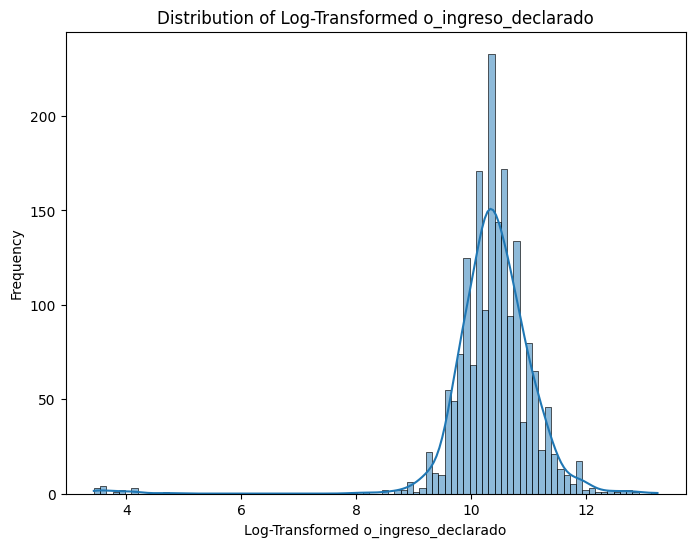

In [560]:
# prompt: Realizar en base a la distribución de la variable 'o_ingreso_declarado', una transformación adecuada aplicar en un modelo predictivo, el resultado debe ser numérico y debe sustituir la variable original.

# Apply a log transformation to 'o_ingreso_declarado' to handle its distribution
# Add a small constant (e.g., 1) before taking the log to handle zero values,
# although based on the describe() output, it seems all values are positive.
# Using np.log1p (log(1+x)) is a robust way to handle potential zeros gracefully.
df['o_ingreso_declarado_log'] = np.log1p(df['o_ingreso_declarado'])

# Replace the original column with the transformed column
df = df.drop('o_ingreso_declarado', axis=1)
df = df.rename(columns={'o_ingreso_declarado_log': 'o_ingreso_declarado'})

# Verify the transformation by checking the distribution and info
print("\nInfo after transformation:")
df.info()

print("\nDescription after transformation:")
display(df['o_ingreso_declarado'].describe())

# Optional: Plot the distribution of the transformed variable to visually inspect
plt.figure(figsize=(8, 6))
sns.histplot(df['o_ingreso_declarado'], kde=True)
plt.title('Distribution of Log-Transformed o_ingreso_declarado')
plt.xlabel('Log-Transformed o_ingreso_declarado')
plt.ylabel('Frequency')
plt.show()


In [561]:

# Análisis de la variable o_ingreso_declarado

# Distribución de o_ingreso_declarado

# Segmentación por cuantiles


# Crear bins basados en los cuantiles

# Transformación sugerida: Logaritmo
# Dada la posible asimetría (sesgo positivo) que se observa en la distribución (histograma),
# una transformación logarítmica (np.log1p para manejar valores cero si los hubiera) podría ayudar
# a hacer la distribución más simétrica, lo que a menudo mejora el rendimiento de modelos lineales
# y modelos basados en distancias.

# Verificar si hay valores no positivos antes de aplicar log

# Visualizar la distribución después de la transformación logarítmica

# La elección entre segmentación por cuantiles y transformación logarítmica (u otra como raíz cuadrada, Box-Cox si es apropiado)
# dependerá del modelo predictivo específico que se vaya a utilizar y de cómo maneja cada transformación.
# - La segmentación por cuantiles crea una variable categórica ordenada. Es útil para modelos basados en árboles
#   o cuando se quiere capturar efectos no lineales de manera simple.
# - La transformación logarítmica hace que la variable sea más numérica y menos sesgada, lo que es beneficioso
#   para modelos lineales o modelos que asumen normalidad o simetría en las características.

# Sugerencia adicional: Root transformation (sqrt) o Box-Cox/Yeo-Johnson
# Si la transformación logarítmica aún deja algo de sesgo o si hay valores <= 0, otras opciones son:
# - Raíz cuadrada: `df['o_ingreso_declarado_sqrt'] = np.sqrt(df['o_ingreso_declarado'])` (si no hay negativos)
# - Box-Cox o Yeo-Johnson: Estas son transformaciones más flexibles que pueden determinar la mejor
#   transformación a partir de los datos. Requieren scikit-learn: `from sklearn.preprocessing import PowerTransformer`
#   `pt = PowerTransformer(method='box-cox')` (solo para positivos) o `pt = PowerTransformer(method='yeo-johnson')` (para cualquier valor).
#   `df['o_ingreso_declarado_transformed'] = pt.fit_transform(df[['o_ingreso_declarado']])`

# Para modelos predictivos, se podría probar tanto la variable segmentada ('o_ingreso_declarado_quantile')
# como la variable transformada numéricamente (e.g., 'o_ingreso_declarado_log') por separado o incluso
# en conjunto para ver cuál mejora el rendimiento.


In [562]:
df_numeric.columns

Index(['o_fpd4', 'o_quincena', 'o_Num_Dia_Sem', 'o_ingreso_estimado',
       'o_ingreso_declarado', 'o_edad', 'o_clr_Score3', 'o_clr_Cancelaciones',
       'o_clr_Consultas', 'o_clr_Incumplimientos', 'o_cdr_tiene_quita',
       'o_cdr_tiene_oca', 'o_cdr_tiene_brou', 'o_cdr_segmento', 'o_pricing',
       'o_scoring', 'm_Deuda', 'm_DeudaPrincipal', 'm_DeudaSec_Prom',
       'm_Entidades', 'm_TieneBco', 'm_TieneFin', 'm_Rel_Deuda_Fin',
       'm_Rel_DeudaPrincipal', 'm_Rel_Contingencia', 'm_Var_dueda_6M',
       'm_Deuda_Var-6', 'm_Rel_VarDeuda_Deuda', 'm_Sin_Ficha', 'm_Malos',
       'm_Q_irregular_12m', 'hora_sin', 'hora_cos'],
      dtype='object')

In [563]:
df.value_counts('o_ingreso_declarado')

,count
o_ingreso_declarado,
10.31,164
10.13,116
10.60,111
9.90,101
10.82,92
...,...
11.74,1
12.61,1
12.68,1


In [564]:
# prompt: Preparar las variables numéricas, en función de la distribucíon de cada una, para aplicarlas en en modelo de aprendizaje automático, de manera que maximice el resultado

from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Select the numerical columns for scaling
numeric_cols_to_scale = ['o_fpd4', 'o_quincena', 'o_Num_Dia_Sem', 'o_ingreso_estimado',
       'o_ingreso_declarado', 'o_edad', 'o_clr_Score3', 'o_clr_Cancelaciones',
       'o_clr_Consultas', 'o_clr_Incumplimientos', 'o_cdr_tiene_quita',
       'o_cdr_tiene_oca', 'o_cdr_tiene_brou', 'o_cdr_segmento', 'o_pricing',
       'o_scoring', 'm_Deuda', 'm_DeudaPrincipal', 'm_DeudaSec_Prom',
       'm_Entidades', 'm_TieneBco', 'm_TieneFin', 'm_Rel_Deuda_Fin',
       'm_Rel_DeudaPrincipal', 'm_Rel_Contingencia', 'm_Var_dueda_6M',
       'm_Deuda_Var-6', 'm_Rel_VarDeuda_Deuda', 'm_Sin_Ficha', 'm_Malos',
       'm_Q_irregular_12m', 'hora_sin', 'hora_cos']

# Filter the list to include only columns present in the DataFrame
existing_numeric_cols_to_scale = [col for col in numeric_cols_to_scale if col in df.columns]

# Handle infinite values in 'm_Rel_Contingencia'
# Replace infinity with the maximum non-infinite value in the column
if 'm_Rel_Contingencia' in existing_numeric_cols_to_scale:
    max_finite_contingencia = df['m_Rel_Contingencia'][np.isfinite(df['m_Rel_Contingencia'])].max()
    df['m_Rel_Contingencia'] = df['m_Rel_Contingencia'].replace([np.inf, -np.inf], max_finite_contingencia)


# Apply MinMaxScaler to the numeric columns
scaler = MinMaxScaler()
# Apply scaling only to the existing numeric columns
df[existing_numeric_cols_to_scale] = scaler.fit_transform(df[existing_numeric_cols_to_scale])

# Display info and the first rows of the DataFrame with scaled numeric variables
print("DataFrame after scaling numeric variables:")
df_numeric_scaled = df.select_dtypes(include=np.number)
df_numeric_scaled.info()
display(df_numeric_scaled.head())

DataFrame after scaling numeric variables:
<class 'pandas.core.frame.DataFrame'>
Index: 1825 entries, 10994184 to 9531591
Data columns (total 33 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   o_fpd4                 1825 non-null   float64
 1   o_quincena             1825 non-null   float64
 2   o_Num_Dia_Sem          1825 non-null   float64
 3   o_ingreso_estimado     1825 non-null   float64
 4   o_edad                 1825 non-null   float64
 5   o_clr_Score3           1825 non-null   float64
 6   o_clr_Cancelaciones    1825 non-null   float64
 7   o_clr_Consultas        1825 non-null   float64
 8   o_clr_Incumplimientos  1825 non-null   float64
 9   o_cdr_tiene_quita      1825 non-null   float64
 10  o_cdr_tiene_oca        1825 non-null   float64
 11  o_cdr_tiene_brou       1825 non-null   float64
 12  o_cdr_segmento         1825 non-null   float64
 13  o_pricing              1825 non-null   float64
 14  o_scorin

,o_fpd4,o_quincena,o_Num_Dia_Sem,o_ingreso_estimado,o_edad,o_clr_Score3,o_clr_Cancelaciones,o_clr_Consultas,o_clr_Incumplimientos,o_cdr_tiene_quita,...,m_Rel_Contingencia,m_Var_dueda_6M,m_Deuda_Var-6,m_Rel_VarDeuda_Deuda,m_Sin_Ficha,m_Malos,m_Q_irregular_12m,hora_sin,hora_cos,o_ingreso_declarado
m_Documento,,,,,,,,,,,,,,,,,,,,,
10994184,1.00,1.00,1.00,0.12,0.90,1.00,0.00,0.00,0.00,0.00,...,0.13,0.02,0.07,0.31,0.00,0.00,0.00,0.25,0.07,0.74
11105982,1.00,1.00,0.67,0.33,0.93,0.75,0.00,0.00,0.00,0.00,...,0.03,1.00,0.11,1.00,0.00,0.00,0.00,0.07,0.25,0.75
11150103,1.00,0.00,0.50,0.16,0.93,0.98,0.00,0.00,0.00,0.00,...,0.02,0.06,0.07,0.82,0.00,0.00,0.00,0.37,0.02,0.74
11349815,1.00,1.00,0.33,0.18,0.92,0.58,0.00,0.00,0.00,0.00,...,0.00,0.24,0.11,0.97,0.00,0.00,0.00,0.07,0.75,0.65
12099611,1.00,1.00,0.17,0.72,0.85,0.52,0.00,0.33,0.00,0.00,...,0.04,0.14,0.12,0.94,0.00,0.00,0.17,0.25,0.07,0.70


In [565]:
df_numeric_scaled.describe()

,o_fpd4,o_quincena,o_Num_Dia_Sem,o_ingreso_estimado,o_edad,o_clr_Score3,o_clr_Cancelaciones,o_clr_Consultas,o_clr_Incumplimientos,o_cdr_tiene_quita,...,m_Rel_Contingencia,m_Var_dueda_6M,m_Deuda_Var-6,m_Rel_VarDeuda_Deuda,m_Sin_Ficha,m_Malos,m_Q_irregular_12m,hora_sin,hora_cos,o_ingreso_declarado
count,1825.00,1825.00,1825.00,1825.00,1825.00,1825.00,1825.00,1825.00,1825.00,1825.00,...,1825.00,1825.00,1824.00,1801.00,1825.00,1825.00,1825.00,1825.00,1825.00,1825.00
mean,0.39,0.50,0.51,0.17,0.38,0.62,0.04,0.39,0.35,0.00,...,0.02,0.22,0.10,0.93,0.11,0.06,0.08,0.28,0.47,0.71
std,0.49,0.50,0.30,0.13,0.21,0.22,0.19,0.42,0.48,0.00,...,0.11,0.24,0.05,0.06,0.24,0.18,0.15,0.27,0.36,0.08
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.33,0.08,0.21,0.48,0.00,0.00,0.00,0.00,...,0.00,0.10,0.08,0.90,0.00,0.00,0.00,0.07,0.15,0.68
50%,0.00,1.00,0.50,0.13,0.34,0.63,0.00,0.33,0.00,0.00,...,0.00,0.13,0.09,0.93,0.00,0.00,0.00,0.25,0.50,0.71
75%,1.00,1.00,0.83,0.22,0.52,0.78,0.00,1.00,1.00,0.00,...,0.01,0.20,0.11,0.96,0.00,0.00,0.08,0.37,0.85,0.75
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [566]:
df_numeric.columns

Index(['o_fpd4', 'o_quincena', 'o_Num_Dia_Sem', 'o_ingreso_estimado',
       'o_ingreso_declarado', 'o_edad', 'o_clr_Score3', 'o_clr_Cancelaciones',
       'o_clr_Consultas', 'o_clr_Incumplimientos', 'o_cdr_tiene_quita',
       'o_cdr_tiene_oca', 'o_cdr_tiene_brou', 'o_cdr_segmento', 'o_pricing',
       'o_scoring', 'm_Deuda', 'm_DeudaPrincipal', 'm_DeudaSec_Prom',
       'm_Entidades', 'm_TieneBco', 'm_TieneFin', 'm_Rel_Deuda_Fin',
       'm_Rel_DeudaPrincipal', 'm_Rel_Contingencia', 'm_Var_dueda_6M',
       'm_Deuda_Var-6', 'm_Rel_VarDeuda_Deuda', 'm_Sin_Ficha', 'm_Malos',
       'm_Q_irregular_12m', 'hora_sin', 'hora_cos'],
      dtype='object')

In [567]:
# Seleccionar las variables numéricas que se discretizarán por cuantiles
vars_to_discretize_quantiles = ['o_ingreso_declarado', 'm_Entidades',
                                 'm_Exposición', 'm_Deuda']

# Discretizar cada variable seleccionada por cuantiles
for col in vars_to_discretize_quantiles:
  if col in df.columns:
    # Crear 4 bins (quintiles) basados en los cuantiles
    df[col + '_quantile_bin'] = pd.qcut(df[col], q=5, labels=False, duplicates='drop')
    # Convertir la nueva columna discretizada a tipo 'category'
    df[col + '_quantile_bin'] = df[col + '_quantile_bin'].astype('category')
  else:
    print(f"Warning: Column '{col}' not found in DataFrame for quantile discretization.")

# Drop original columns only if they exist in the DataFrame
original_cols_to_drop = [col for col in vars_to_discretize_quantiles if col in df.columns]
df = df.drop(original_cols_to_drop, axis=1)


# Mostrar las primeras filas del DataFrame con las nuevas variables discretizadas
print("\nDataFrame después de discretizar por cuantiles:")
display(df.head())

# Mostrar la información del DataFrame para ver los tipos de datos de las
# nuevas columnas
df.info()


DataFrame después de discretizar por cuantiles:


,o_fpd4,o_quincena,o_Num_Dia_Sem,o_ingreso_estimado,o_edad,o_clr_Score3,o_clr_Cancelaciones,o_clr_Consultas,o_clr_Incumplimientos,o_cdr_tiene_quita,...,m_Grupo_i_A,m_Grupo_i_B1,m_Grupo_i_C,m_Grupo_i_C1,m_Situacion-6CDR_Buena,m_Situacion-6CDR_Mejor,m_Situacion-6CDR_Peor,o_ingreso_declarado_quantile_bin,m_Entidades_quantile_bin,m_Deuda_quantile_bin
m_Documento,,,,,,,,,,,,,,,,,,,,,
10994184,1.00,1.00,1.00,0.12,0.90,1.00,0.00,0.00,0.00,0.00,...,False,True,False,False,True,False,False,3,0,0
11105982,1.00,1.00,0.67,0.33,0.93,0.75,0.00,0.00,0.00,0.00,...,False,True,False,False,True,False,False,3,0,2
11150103,1.00,0.00,0.50,0.16,0.93,0.98,0.00,0.00,0.00,0.00,...,False,False,True,False,True,False,False,3,1,1
11349815,1.00,1.00,0.33,0.18,0.92,0.58,0.00,0.00,0.00,0.00,...,False,True,False,False,True,False,False,0,0,2
12099611,1.00,1.00,0.17,0.72,0.85,0.52,0.00,0.33,0.00,0.00,...,False,True,False,False,False,False,True,1,2,3


<class 'pandas.core.frame.DataFrame'>
Index: 1825 entries, 10994184 to 9531591
Data columns (total 94 columns):
 #   Column                                            Non-Null Count  Dtype   
---  ------                                            --------------  -----   
 0   o_fpd4                                            1825 non-null   float64 
 1   o_quincena                                        1825 non-null   float64 
 2   o_Num_Dia_Sem                                     1825 non-null   float64 
 3   o_ingreso_estimado                                1825 non-null   float64 
 4   o_edad                                            1825 non-null   float64 
 5   o_clr_Score3                                      1825 non-null   float64 
 6   o_clr_Cancelaciones                               1825 non-null   float64 
 7   o_clr_Consultas                                   1825 non-null   float64 
 8   o_clr_Incumplimientos                             1825 non-null   float64 
 9   o_c

In [568]:
df.describe()

,o_fpd4,o_quincena,o_Num_Dia_Sem,o_ingreso_estimado,o_edad,o_clr_Score3,o_clr_Cancelaciones,o_clr_Consultas,o_clr_Incumplimientos,o_cdr_tiene_quita,...,m_Rel_DeudaPrincipal,m_Rel_Contingencia,m_Var_dueda_6M,m_Deuda_Var-6,m_Rel_VarDeuda_Deuda,m_Sin_Ficha,m_Malos,m_Q_irregular_12m,hora_sin,hora_cos
count,1825.00,1825.00,1825.00,1825.00,1825.00,1825.00,1825.00,1825.00,1825.00,1825.00,...,1825.00,1825.00,1825.00,1824.00,1801.00,1825.00,1825.00,1825.00,1825.00,1825.00
mean,0.39,0.50,0.51,0.17,0.38,0.62,0.04,0.39,0.35,0.00,...,0.66,0.02,0.22,0.10,0.93,0.11,0.06,0.08,0.28,0.47
std,0.49,0.50,0.30,0.13,0.21,0.22,0.19,0.42,0.48,0.00,...,0.24,0.11,0.24,0.05,0.06,0.24,0.18,0.15,0.27,0.36
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.33,0.08,0.21,0.48,0.00,0.00,0.00,0.00,...,0.48,0.00,0.10,0.08,0.90,0.00,0.00,0.00,0.07,0.15
50%,0.00,1.00,0.50,0.13,0.34,0.63,0.00,0.33,0.00,0.00,...,0.64,0.00,0.13,0.09,0.93,0.00,0.00,0.00,0.25,0.50
75%,1.00,1.00,0.83,0.22,0.52,0.78,0.00,1.00,1.00,0.00,...,0.88,0.01,0.20,0.11,0.96,0.00,0.00,0.08,0.37,0.85
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [569]:
# Define 'Zero' como la variable objetivo
y = df['o_fpd4']

# Divide los datos en conjuntos de entrenamiento y prueba
X_df = df.drop('o_fpd4', axis=1)

num_data_points = len(X_df)
cut = int(.7 * num_data_points)

X_train = X_df[:cut]
y_train = y[:cut] # Usa la variable objetivo correcta 'y'
X_test = X_df[cut:]
y_test = y[cut:]
print(X_train.shape, X_test.shape)

(1277, 93) (548, 93)


In [570]:
from sklearn import linear_model
from sklearn.impute import SimpleImputer
import numpy as np

# Impute missing values using the mean of the training data
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

# Fit on training data and transform both training and testing data
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

logistic = linear_model.LogisticRegression(max_iter=1000, solver='liblinear')
logistic.fit(X_train_imputed, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [571]:
print('Logistic Regression mean accuracy: %f' % logistic.score(X_test_imputed, y_test))

Logistic Regression mean accuracy: 0.759124


              precision    recall  f1-score   support

         0.0       0.75      0.82      0.78       288
         1.0       0.78      0.69      0.73       260

    accuracy                           0.76       548
   macro avg       0.76      0.76      0.76       548
weighted avg       0.76      0.76      0.76       548

Confusion Matrix:
[[237  51]
 [ 81 179]]


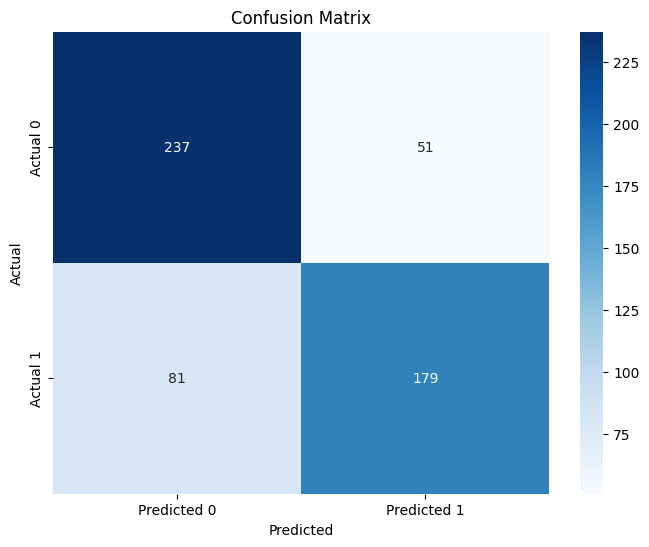

In [572]:
#Evalúo el resultado del modelo LogisticRegression.

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predict on the test set
y_pred = logistic.predict(X_test_imputed)

# Evaluate the model
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

                Feature  Importance
81          m_Grupo_b_R        1.79
21       m_Var_dueda_6M        1.34
82         m_Grupo_b_RR        0.88
69   m_1PEORCATBCU6M_00        0.86
20   m_Rel_Contingencia        0.81
5   o_clr_Cancelaciones        0.71
22        m_Deuda_Var-6        0.60
71   m_1PEORCATBCU6M_2A        0.51
24          m_Sin_Ficha        0.48
33   o_cargo_BPS / AFAP        0.46


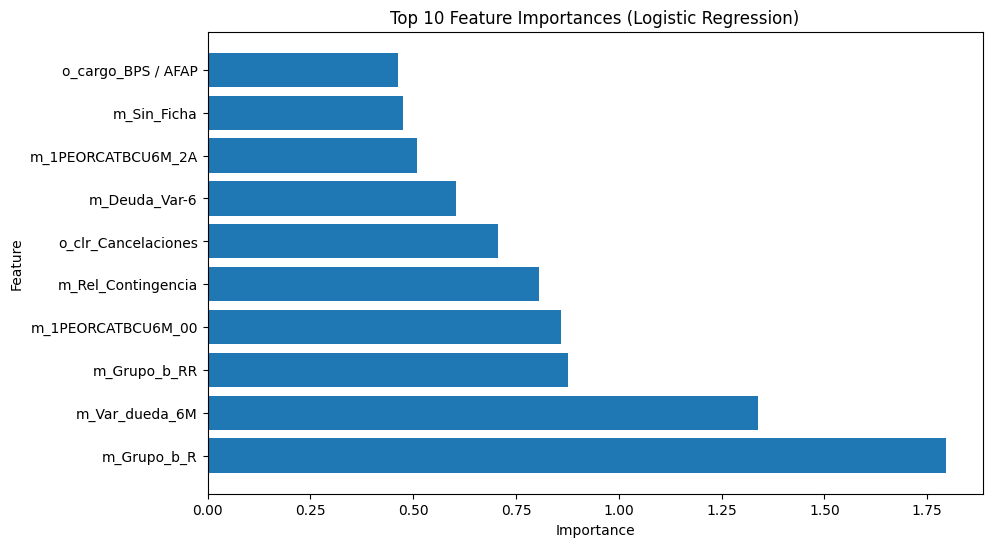

In [573]:

feature_importances = logistic.coef_[0]

# Create a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the top N features (e.g., top 10)
print(feature_importance_df.head(10))


# Visualize feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'][:10], feature_importance_df['Importance'][:10])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importances (Logistic Regression)')
plt.show()